Optimal Bidding based pn adjusted cost for data with ntb_view_attributed_units_sold >0 and not in blank

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file to explore its content and structure
campaign_data = pd.read_csv('Amazon Ads All.csv')

# Display the first few rows of the dataframe and the column names to understand the dataset
campaign_data.head(), campaign_data.columns

(   ADV_ID    AD_ID         SKU     placement_slot  impressions  clicks  \
 0   84373  6370624  9985955750  offsite_mobileweb         1089       0   
 1   84373  1295011  7875390725    offsite_desktop         2043       0   
 2   84373  6370624  9985955750  offsite_mobileweb         1452       0   
 3   84373  1295011  7875390725    offsite_desktop         1312       0   
 4   84373  1295011  7875390725  offsite_mobileapp            8       0   
 
    auction_cost  adjusted_cost hit_day_utc  \
 0      10.89000        8.79000    02/05/24   
 1      26.61464       19.44791    01/05/24   
 2      14.52000       11.68400    01/05/24   
 3      16.59940       11.94286    30/04/24   
 4       0.11608        0.07161    01/05/24   
 
                                  targeting_secondary    vertical  \
 0       category=Automotive Replacement Control Arms  Automotive   
 1         category=Automotive Replacement Brake Kits  Automotive   
 2       category=Automotive Replacement Control Arms  Au

In [2]:
# Attempt to parse dates in the '%d/%m/%y' format
campaign_data['hit_day_utc_parsed'] = pd.to_datetime(campaign_data['hit_day_utc'], format='%d/%m/%y', errors='coerce')

# Parse remaining unparsed dates in the '%Y-%m-%d %H:%M:%S' format
mask = campaign_data['hit_day_utc_parsed'].isna()
campaign_data.loc[mask, 'hit_day_utc_parsed'] = pd.to_datetime(campaign_data.loc[mask, 'hit_day_utc'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Check for any remaining non-parsed dates
remaining_non_parsed = campaign_data[campaign_data['hit_day_utc_parsed'].isna()]
if not remaining_non_parsed.empty:
    print("Remaining non-parsed dates:")
    print(remaining_non_parsed)

campaign_data['month_name'] = campaign_data['hit_day_utc_parsed'].dt.strftime('%B')  # Get month names
campaign_data['day_name'] = campaign_data['hit_day_utc_parsed'].dt.strftime('%A')    # Get day names


# Fill missing values
campaign_data.fillna({
    'vertical': 'unknown',
    'sub_vertical': 'unknown',
    'ntb_click_attributed_units_sold': 0,
    'ntb_view_attributed_units_sold': 0,
    'ntb_click_attributed_orders': 0,
    'ntb_view_attributed_orders': 0,
    'view_attributed_units_sold': 0,
    'view_attributed_orders': 0
}, inplace=True)

# Filter the dataset
filtered_data = campaign_data[(campaign_data['ntb_view_attributed_units_sold'] >= 1)]

filtered_data.head()

ADV_ID    AD_ID         SKU     placement_slot  impressions  clicks  \
22   13764  5531371  4319439787  offsite_mobileweb         1548       0   
23   38809  6546675  8679081349  offsite_mobileweb         8686       0   
25   45520  5831337  5662642140  offsite_mobileweb         1961       0   
30   76802  9259665  8352057740  offsite_mobileapp           77       0   
35   13386  6532070  6004552148  offsite_mobileweb          246       0   

    auction_cost  adjusted_cost hit_day_utc  \
22      15.48000       12.79320    01/05/24   
23      86.86000       71.75718    01/05/24   
25      19.61000       15.95270    01/05/24   
30       1.45342        0.72075    01/05/24   
35       2.46000        1.97800    02/05/24   

                             targeting_secondary  ...        sub_vertical  \
22             category=Tumblers & Water Glasses  ...             Kitchen   
23                  content-category=Young Adult  ...      Sporting Goods   
25             category=Granola & Nutrition Bars  ...      Grocery - Food   
30  category=Single-Serve Coffee Capsules & Pods  ...  Grocery - Beverage   
35              category=Baby Bottle Sterilizers  ...    Baby Consumables   

   ntb_click_attributed_units_sold  ntb_view_attributed_units_sold  \
22                             0.0                             1.0   
23                             0.0                             1.0   
25                             0.0                             1.0   
30                             0.0                             1.0   
35                             0.0                             2.0   

    ntb_click_attributed_orders  ntb_view_attributed_orders  \
22                          0.0                         1.0   
23                          0.0                         1.0   
25                          0.0                         1.0   
30                          0.0                         1.0   
35                          0.0                         1.0   

    view_attributed_units_sold  view_attributed_orders  hit_day_utc_parsed  \
22                         1.0                     1.0          2024-05-01   
23                         1.0                     1.0          2024-05-01   
25                         1.0                     1.0          2024-05-01   
30                         1.0                     1.0          2024-05-01   
35                         2.0                     1.0          2024-05-02   

   month_name   day_name  
22        May  Wednesday  
23        May  Wednesday  
25        May  Wednesday  
30        May  Wednesday  
35        May   Thursday  

[5 rows x 21 columns]

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define features and target for adjusted cost
features_cost = [ 'clicks', 'targeting_secondary', 'placement_slot', 'month_name', 'day_name']
target_cost = 'adjusted_cost'

# Prepare the data
X_cost = campaign_data[features_cost]
y_cost = campaign_data[target_cost]

# One-hot encode categorical features and standardize numerical features
preprocessor_cost = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [ 'clicks']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])
    ])

# Define and train the Gradient Boosting Regressor for adjusted cost
model_cost = Pipeline(steps=[
    ('preprocessor', preprocessor_cost),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

X_train_cost, X_test_cost, y_train_cost, y_test_cost = train_test_split(X_cost, y_cost, test_size=0.2, random_state=42)
model_cost.fit(X_train_cost, y_train_cost)

# Predict and evaluate the adjusted cost model
y_pred_cost = model_cost.predict(X_test_cost)
mse_cost = mean_squared_error(y_test_cost, y_pred_cost)
mae_cost = mean_absolute_error(y_test_cost, y_pred_cost)
r2_cost = r2_score(y_test_cost, y_pred_cost)

# Display the evaluation metrics for adjusted cost model
print(f"Adjusted Cost Model - Mean Squared Error: {mse_cost}")
print(f"Adjusted Cost Model - Mean Absolute Error: {mae_cost}")
print(f"Adjusted Cost Model - R-squared: {r2_cost}")

# Get feature names after one-hot encoding
encoded_feature_names_cost = model_cost.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['targeting_secondary', 'placement_slot', 'month_name', 'day_name'])

# Combine original numerical features with encoded categorical features
all_features_cost = ['clicks'] + list(encoded_feature_names_cost)

# Calculate feature importance
importance_cost = model_cost.named_steps['regressor'].feature_importances_
feature_importance_cost = pd.DataFrame({
    'Feature': all_features_cost,
    'Importance': importance_cost
}).sort_values(by='Importance', ascending=False)

print("Feature Importance for Adjusted Cost Model:")
pd.set_option('display.max_rows', None)
print(feature_importance_cost)

Adjusted Cost Model - Mean Squared Error: 450.1376091283562
Adjusted Cost Model - Mean Absolute Error: 11.443322806725593
Adjusted Cost Model - R-squared: 0.5989381511204588
Feature Importance for Adjusted Cost Model:
                                                Feature  Importance
2396  targeting_secondary_category=Women's Running S...    0.239753
2489                   placement_slot_offsite_mobileapp    0.229338
0                                                clicks    0.150669
1120        targeting_secondary_category=Home & Kitchen    0.052718
890      targeting_secondary_category=Foundation Makeup    0.048985
2480    targeting_secondary_content-category=Soap Opera    0.042672
2492                                month_name_February    0.040879
2488                     placement_slot_offsite_desktop    0.024889
1950  targeting_secondary_category=Single-Serve Coff...    0.023337
1262     targeting_secondary_category=Kids' Electronics    0.018773
1917  targeting_secondary_category

In [4]:
pd.set_option('display.max_colwidth', None)
print(feature_importance_cost)

                                                                                       Feature  \
2396                                        targeting_secondary_category=Women's Running Shoes   
2489                                                          placement_slot_offsite_mobileapp   
0                                                                                       clicks   
1120                                               targeting_secondary_category=Home & Kitchen   
890                                             targeting_secondary_category=Foundation Makeup   
2480                                           targeting_secondary_content-category=Soap Opera   
2492                                                                       month_name_February   
2488                                                            placement_slot_offsite_desktop   
1950                          targeting_secondary_category=Single-Serve Coffee Capsules & Pods   
1262                

In [7]:
def bidding_strategy(row, feature_importance):
    # Extracting feature names and their importance
    important_features = feature_importance.head(10)['Feature'].values
    
    # Initialize bid adjustment factor
    bid_factor = 1.0
    
    # Adjust bid based on placement slot
    if 'placement_slot_offsite_mobileapp' in important_features and row['placement_slot'] == 'offsite_mobileapp':
        bid_factor *= 1.2  # Increase bid by 10%
    if 'placement_slot_offsite_desktop' in important_features and row['placement_slot'] == 'offsite_desktop':
        bid_factor *= 1.1  # Increase bid by 5%
    if 'placement_slot_offsite_mobileweb' in important_features and row['placement_slot'] == 'offsite_mobileweb':
        bid_factor *= 1.05  # Increase bid by 5%

    # Adjust bid based on targeting secondary categories
    high_value_categories = [
        'category=Women\'s Running Shoes', 
        'category=Foundation Makeup',
        'category=Home & Kitchen',
        'category=Soap Opera',
        'category=Single-Serve Coffee Capsules & Pods',
        'category=Sheet & Pillowcase Sets',
        "category=Kids' Electronics",
        'category=Oral Care Products',
        'category=Sports Fan Shop',
        'category=Hair Loss Products'
    ]
    if row['targeting_secondary'] in high_value_categories:
        bid_factor *= 1.5  # Increase bid by 10%

    # Adjust bid based on month
    important_months = ['February', 'March']
    if row['month_name'] in important_months:
        bid_factor *= 1.2  # Increase bid by 5%

    # Adjust bid based on day of the week
    important_days = ['Saturday', 'Sunday']
    if row['day_name'] in important_days:
        bid_factor *= 1.1  # Increase bid by 5%

    # Calculate optimized bid
    return row['adjusted_cost'] * bid_factor

# Apply the bidding strategy to the data
filtered_data['optimized_bid'] = filtered_data.apply(lambda row: bidding_strategy(row, feature_importance_cost), axis=1)

# Display the updated dataset with optimized bids
print(filtered_data[['adjusted_cost', 'optimized_bid']].head())


    adjusted_cost  optimized_bid
22       12.79320       12.79320
23       71.75718       71.75718
25       15.95270       15.95270
30        0.72075        1.29735
35        1.97800        1.97800


/var/folders/80/ghdt2w012_x2yg018vx45m300000gn/T/ipykernel_37258/2428740090.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['optimized_bid'] = filtered_data.apply(lambda row: bidding_strategy(row, feature_importance_cost), axis=1)


/var/folders/80/ghdt2w012_x2yg018vx45m300000gn/T/ipykernel_37258/1151497643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['adjusted_cost_diff'] = filtered_data['optimized_bid'] - filtered_data['adjusted_cost']


       adjusted_cost  optimized_bid  adjusted_cost_diff
count  110412.000000  110412.000000       110412.000000
mean       27.160959      42.436368           15.275409
std        43.532047      77.201933           36.501337
min         0.000000       0.000000            0.000000
25%         0.386000       0.643680            0.078191
50%         8.976590      10.934220            1.416960
75%        40.622120      50.403573            9.717050
max      1066.991630    1408.428952          667.983151


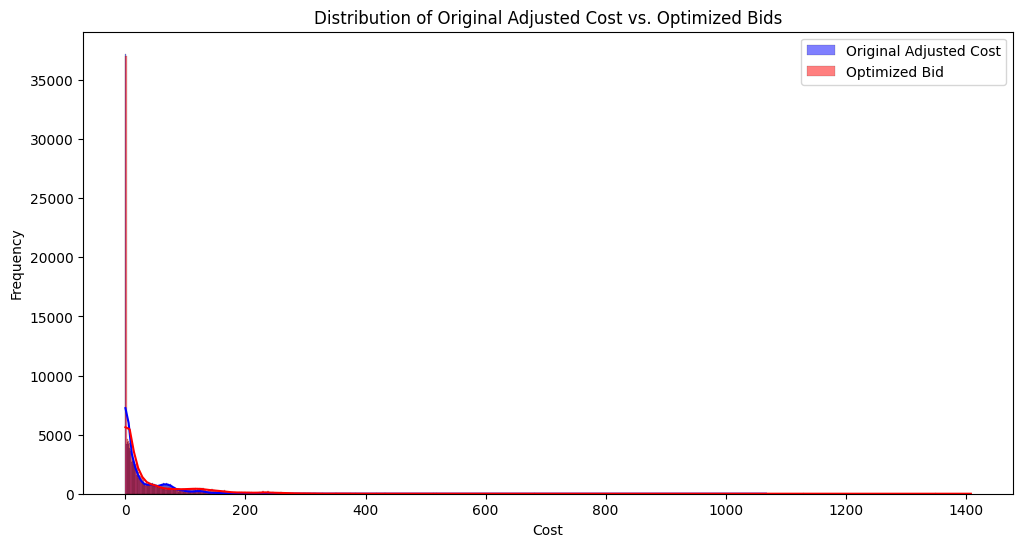

In [8]:
# Calculate the change in adjusted cost after applying the optimized bids
filtered_data['adjusted_cost_diff'] = filtered_data['optimized_bid'] - filtered_data['adjusted_cost']

# Calculate summary statistics
summary_stats = filtered_data[['adjusted_cost', 'optimized_bid', 'adjusted_cost_diff']].describe()
print(summary_stats)

# Visualize the distribution of original and optimized bids
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['adjusted_cost'], color='blue', label='Original Adjusted Cost', kde=True)
sns.histplot(filtered_data['optimized_bid'], color='red', label='Optimized Bid', kde=True)
plt.legend()
plt.title('Distribution of Original Adjusted Cost vs. Optimized Bids')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()
